In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.autopredictors.scripts.virt_scan_data import plotting_default_params


from general_tools.notebook.tf import reset_tf_graph                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable


from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [57]:
n_pc_samples = 2048
# experiment_name = 'all_snc_rotated_conv_arch_2048pts_emd'
# experiment_name = 'all_snc_rotated_conv_arch_2048pts_emd'
experiment_name = 'all_snc_rotated_conv_arch_2048pts_emd'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]
ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1110.


In [59]:
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
print syn_id

Give me the class type.
table
04379243


In [60]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

full_pclouds_path = osp.join(full_pclouds_path, syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)

In [61]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

model_unames = full_model_names + '_' + full_syn_ids
train_data = PointCloudDataSet(full_pclouds, labels=full_model_names, init_shuffle=False)

8509 files containing complete point clouds were found.


In [62]:
_, latent_emb, _ = latent_embedding_of_entire_dataset(train_data, ae, conf)
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=1).fit(latent_emb)

[33, 44, 5, 44] [[ 2.84094533]]


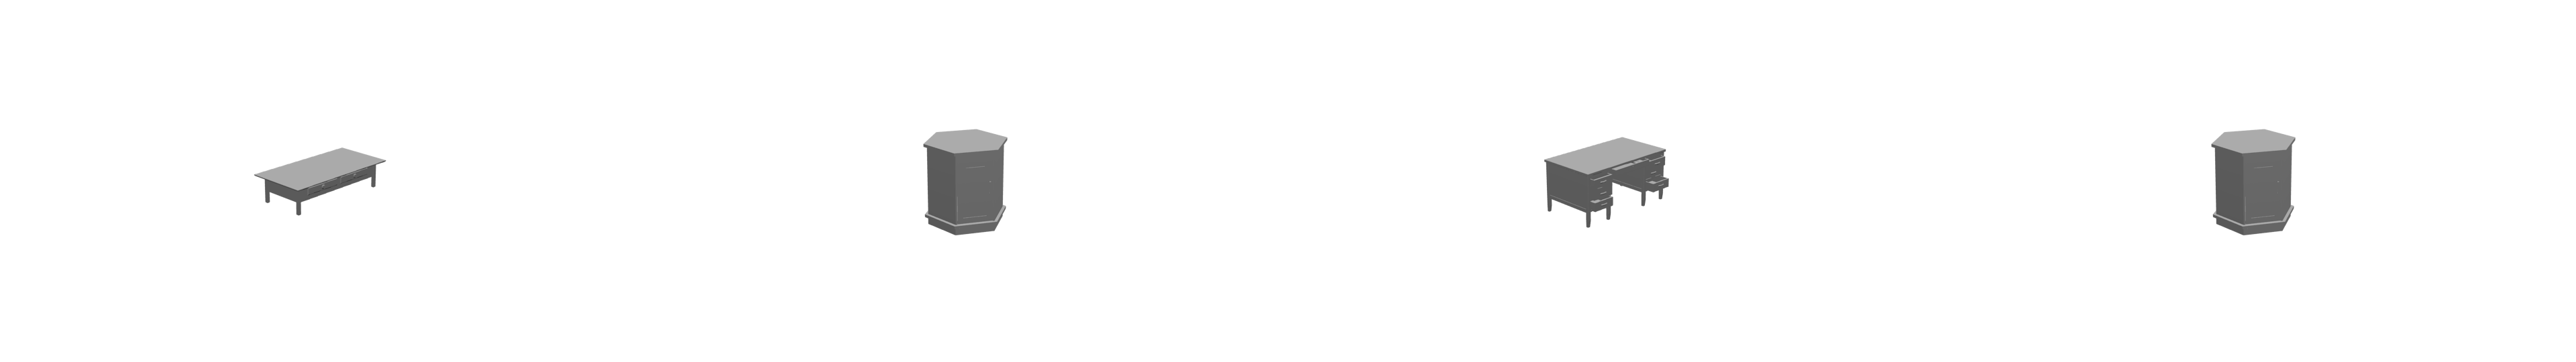

In [75]:
triplet = [33, 44, 5]

target = latent_emb[triplet[2]] + latent_emb[triplet[1]] - latent_emb[triplet[0]]
distance, index = nn.kneighbors(target.reshape(1, -1))

triplet.append(index[0][0])
print triplet, distance

top_image_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/Meshes/Shape_Net_Core/2015_Summer_OUT/Images/' + syn_id
image_setting = 'image_p020_t315_r005.png'
triplet_im_files = [osp.join(top_image_dir, i, image_setting) for i in full_model_names[triplet]]

from general_tools.plotting import stack_images_horizontally, stack_images_in_square_grid
stack_images_horizontally_2(triplet_im_files, 'lala.png')
# stack_images_in_square_grid(triplet_im_files)

In [23]:

from PIL import Image
def stack_images_horizontally_2(file_names, save_file=None):
    ''' Opens the images corresponding to file_names and
    creates a new image stacking them horizontally.
    '''
    images = map(Image.open, file_names)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGBA', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    if save_file is not None:
        new_im.save(save_file)
    return new_im